In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction and Objective
## Debugging the data used for training with MultiTask Learning

This notebook should be executed after `train_test_split.ipynb`

In [11]:
import h5py
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from utils import (
    HDF5MultitaskDataset,
    ResizeTransform,
    Coord2HeatmapTransform,
    CustomToTensor,
    MultitaskCollator,
    plot_image_landmarks,
    plot_many_heatmaps,
    nested_dict_to_easydict
)

In [12]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', None)

# load parameters

In [13]:
with open("../../code_configs/params.yaml") as f:
    PARAMS = yaml.safe_load(f)
    PARAMS = nested_dict_to_easydict(PARAMS)

In [14]:
print(PARAMS)

{'RAW_DATA_DIRECTORY': '../../data/raw', 'INTERMEDIATE_DATA_DIRECTORY': '../../data/intermediate', 'PRIMARY_DATA_DIRECTORY': '../../data/primary', 'ARTIFACTS_DATA_DIRECTORY': '../../artifacts', 'DATASET_1_RAW_ZIP_FILE_NAME': 'radiography-20221212T190109Z-001.zip', 'DATASET_1_RAW_ZIP_NEW_ANNOT_FILE_NAME': 'label_edited-20230122T143005Z-001.zip', 'DATASET_1_INTERMEDIATE_DIR_NAME': 'dataset_1', 'DATASET_1_UNWANTED_JSON_FIELDS': ['imageData'], 'DATASET_3_RAW_RAR_FILE_NAME': 'RawImage.rar', 'DATASET_3_RAW_DIR_NAME_TEMP': 'dataset_3_bmp', 'DATASET_3_RAW_DIR_NAME': 'dataset_3_raw_data', 'UNWANTED_JSON_FIELDS': ['imageData', 'imagePath'], 'DATASET_1_INTERM_DIR_NAME': 'dataset_1_interm_data-20230513T084705Z-001', 'DATASET_1_INTERM_IMG_DIR_NAME': ['image'], 'DATASET_1_INTERM_V_LANDMARKS_DIR_NAME': ['label'], 'DATASET_1_INTERM_F_LANDMARKS_DIR_NAME': None, 'DATASET_2_INTERM_DIR_NAME': 'dataset_2_interm_data-20230304T160421Z-001', 'DATASET_2_INTERM_IMG_DIR_NAME': ['image'], 'DATASET_2_INTERM_V_LAND

In [15]:
metadata_table = pd.read_hdf(
    os.path.join(PARAMS.PRIMARY_DATA_DIRECTORY, PARAMS.TRAIN.METADATA_TABLE_NAME),
    key='df',
)

In [16]:
metadata_table.head()

,v_annots_present,f_annots_present,edges_present,f_annots_rows,f_annots_cols,harmonized_id,v_annots_2_rows,v_annots_2_cols,v_annots_3_rows,v_annots_3_cols,v_annots_4_rows,v_annots_4_cols,source_image_filename,dataset,dev_set,valid,split
0,True,False,True,NaN,NaN,041281ee7fb89f6835a71c309b3b503e3d5a68fc46a608...,3.0,2.0,5.0,2.0,5.0,2.0,45.jpg,dataset_1,NaN,True,undefined
1,True,False,True,NaN,NaN,2cfa37a69916c8a45a51bb8beeb04425e07d2a22f694e0...,3.0,2.0,5.0,2.0,5.0,2.0,92.jpg,dataset_1,NaN,True,undefined
2,True,False,True,NaN,NaN,7201dc2be0b97f59a7901004d6496bbe84c440530776db...,3.0,2.0,5.0,2.0,5.0,2.0,43.jpg,dataset_1,NaN,True,undefined
3,True,False,True,NaN,NaN,2cd4487c03c72d1016ea0a72d1b21eb987878c90ae9eff...,3.0,2.0,5.0,2.0,5.0,2.0,7.jpg,dataset_1,NaN,True,undefined
4,True,False,True,NaN,NaN,27624a6eb37bbc8aafabe2075f423d573b189eae6f23fb...,3.0,2.0,5.0,2.0,5.0,2.0,121.jpg,dataset_1,NaN,True,undefined


In [17]:
metadata_table.describe()

,v_annots_2_rows,v_annots_2_cols,v_annots_3_rows,v_annots_3_cols,v_annots_4_rows,v_annots_4_cols
count,576.000000,576.0,576.0,576.0,578.0,578.0
mean,3.006944,2.0,5.0,2.0,5.0,2.0
std,0.117749,0.0,0.0,0.0,0.0,0.0
min,3.000000,2.0,5.0,2.0,5.0,2.0
25%,3.000000,2.0,5.0,2.0,5.0,2.0
50%,3.000000,2.0,5.0,2.0,5.0,2.0
75%,3.000000,2.0,5.0,2.0,5.0,2.0
max,5.000000,2.0,5.0,2.0,5.0,2.0


In [18]:
display(metadata_table.groupby('split').apply(lambda x: x.loc[:,['v_annots_present', 'f_annots_present']].describe()))

v_annots_present f_annots_present
split                                             
test      count                97               97
          unique                2                2
          top                True             True
          freq                 86               80
train     count               284              284
          unique                2                2
          top                True             True
          freq                262              237
undefined count               146              146
          unique                2                2
          top                True            False
          freq                144              142
val       count                94               94
          unique                2                2
          top                True             True
          freq                 86               79

# Data for task 2 of the training

In [19]:
# define the task id
task_id = 2

# create the right list of paths
train_file_list = metadata_table.loc[
    (metadata_table['split']=='train') & (
    metadata_table['edges_present']==True) & (
    metadata_table['v_annots_present']==True
    ), ['harmonized_id']
].to_numpy().ravel().tolist()

train_file_list = [
    os.path.join(PARAMS.PRIMARY_DATA_DIRECTORY, file_path+'.hdf5') for file_path in train_file_list
]

# instantiate the transforms
my_transforms = transforms.Compose([
    ResizeTransform(tuple(PARAMS.TRAIN.TARGET_IMAGE_SIZE)),
    CustomToTensor(),
])

# instantiate the dataset and dataloader objects
train_dataset = HDF5MultitaskDataset(
    file_paths=train_file_list,
    task_id=task_id,
    transforms=my_transforms,
)
collator_task = MultitaskCollator(
    task_id=task_id,
)
dataloader = DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
    collate_fn=collator_task
)

In [20]:
for batch in dataloader:
    print(type(batch))
    # Train the model on this batch
    break

<class 'dict'>


In [21]:
batch = [{k:v[i] for k, v in batch.items()} for i in range(len(batch['image']))]

<class 'torch.Tensor'>
edges:  torch.Size([1, 256, 256])



/home/samehr/Desktop/cephal/cvmt/notebooks/ml/utils.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, rotation=45)


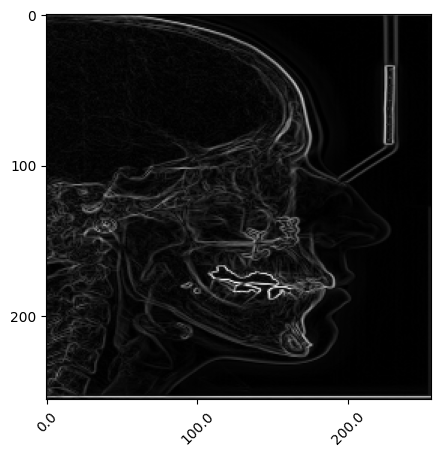

In [22]:
samples = []
v_shapes = []
for i, sample in enumerate(batch):
    print(type(sample['edges']))
    print("edges: ", sample['edges'].shape)
    if 'v_landmarks'in sample and sample['v_landmarks'] is not None:
        print("v_landmarks: ", sample['v_landmarks'].shape)
    if 'f_landmarks' in sample and sample['f_landmarks'] is not None:
        print("f_landmarks: ", sample['f_landmarks'].shape)
    print()

    # plot
    v_landmarks = sample['v_landmarks'] if 'v_landmarks' in sample else None
    f_landmarks = sample['f_landmarks'] if 'f_landmarks' in sample else None
    edges = sample['edges'][0,...]

    plot_image_landmarks(
        edges,
        v_landmarks,
        f_landmarks,
    )
    print()
    break

# Data for task 3 of the training

In [23]:
# define the task id
task_id = 3

# create the right list of paths
train_file_list = metadata_table.loc[
    (metadata_table['split']=='train') & (metadata_table['v_annots_present']==True), ['harmonized_id']
].to_numpy().ravel().tolist()

train_file_list = [
    os.path.join(PARAMS.PRIMARY_DATA_DIRECTORY, file_path+'.hdf5') for file_path in train_file_list
]

# instantiate the transforms
my_transforms = transforms.Compose([
    ResizeTransform(tuple(PARAMS.TRAIN.TARGET_IMAGE_SIZE)),
    CustomToTensor(),
])

# instantiate the dataset and dataloader objects
train_dataset = HDF5MultitaskDataset(
    file_paths=train_file_list,
    task_id=task_id,
    transforms=my_transforms,
)
collator_task = MultitaskCollator(
    task_id=task_id,
)
dataloader = DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
    collate_fn=collator_task
)

### sanity check the dataset and dataloader

In [24]:
for batch in dataloader:
    print(type(batch))
    # Train the model on this batch
    break

<class 'dict'>


In [25]:
batch = [{k:v[i] for k, v in batch.items()} for i in range(len(batch['image']))]

<class 'torch.Tensor'>
image:  torch.Size([1, 256, 256])
v_landmarks:  torch.Size([13, 2])



/home/samehr/Desktop/cephal/cvmt/notebooks/ml/utils.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, rotation=45)


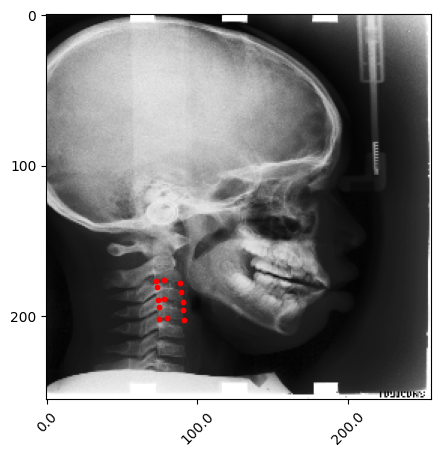

In [26]:
for i, sample in enumerate(batch):
    print(type(sample['image']))
    print("image: ", sample['image'].shape)
    if 'v_landmarks'in sample and sample['v_landmarks'] is not None:
        print("v_landmarks: ", sample['v_landmarks'].shape)
    if 'f_landmarks' in sample and sample['f_landmarks'] is not None:
        print("f_landmarks: ", sample['f_landmarks'].shape)
    print()

    # plot
    v_landmarks = sample['v_landmarks'] if 'v_landmarks' in sample else None
    f_landmarks = sample['f_landmarks'] if 'f_landmarks' in sample else None
    image = sample['image'][0,...]

    plot_image_landmarks(
        image,
        v_landmarks,
        f_landmarks,
    )
    print()
    break

# Data for task 4 of the training

In [27]:
# define the task id
task_id = 4

# create the right list of paths
train_file_list = metadata_table.loc[
    (metadata_table['split']=='train') & (metadata_table['f_annots_present']==True), ['harmonized_id']
].to_numpy().ravel().tolist()

train_file_list = [
    os.path.join(PARAMS.PRIMARY_DATA_DIRECTORY, file_path+'.hdf5') for file_path in train_file_list
]

# instantiate the transforms
my_transforms = transforms.Compose([
    ResizeTransform(tuple(PARAMS.TRAIN.TARGET_IMAGE_SIZE)),
    CustomToTensor(),
])

# instantiate the dataset and dataloader objects
train_dataset = HDF5MultitaskDataset(
    file_paths=train_file_list,
    task_id=task_id,
    transforms=my_transforms,
)
collator_task = MultitaskCollator(
    task_id=task_id,
)
dataloader = DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
    collate_fn=collator_task
)

### sanity check the dataset and dataloader

In [28]:
for batch in dataloader:
    print(type(batch))
    # Train the model on this batch
    break

<class 'dict'>


In [29]:
batch = [{k:v[i] for k, v in batch.items()} for i in range(len(batch['image']))]

<class 'torch.Tensor'>
image:  torch.Size([1, 256, 256])
f_landmarks:  torch.Size([19, 2])



/home/samehr/Desktop/cephal/cvmt/notebooks/ml/utils.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, rotation=45)


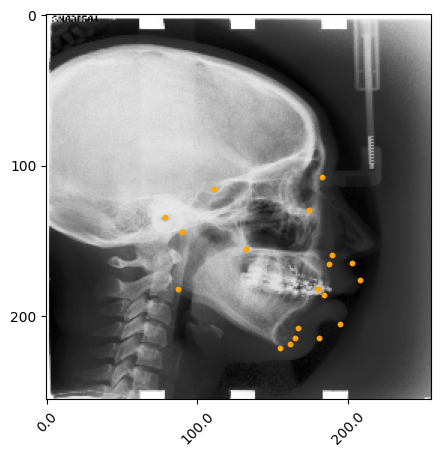

In [30]:
samples = []
v_shapes = []
for i, sample in enumerate(batch):
    print(type(sample['image']))
    print("image: ", sample['image'].shape)
    if 'v_landmarks'in sample and sample['v_landmarks'] is not None:
        print("v_landmarks: ", sample['v_landmarks'].shape)
    if 'f_landmarks' in sample and sample['f_landmarks'] is not None:
        print("f_landmarks: ", sample['f_landmarks'].shape)
    print()

    # plot
    v_landmarks = sample['v_landmarks'] if 'v_landmarks' in sample else None
    f_landmarks = sample['f_landmarks'] if 'f_landmarks' in sample else None
    image = sample['image'][0,...]

    plot_image_landmarks(
        image,
        v_landmarks,
        f_landmarks,
    )
    print()
    break

# Sanity check transformed coordinate landmarks to heatmaps

## Task 3

In [33]:
# define the task id
task_id = 3

# create the right list of paths
train_file_list = metadata_table.loc[
    (metadata_table['split']=='train') & (metadata_table['v_annots_present']==True), ['harmonized_id']
].to_numpy().ravel().tolist()

train_file_list = [
    os.path.join(PARAMS.PRIMARY_DATA_DIRECTORY, file_path+'.hdf5') for file_path in train_file_list
]

# instantiate the transforms
my_transforms = transforms.Compose([
    ResizeTransform(tuple(PARAMS.TRAIN.TARGET_IMAGE_SIZE)),
    Coord2HeatmapTransform(
        tuple(PARAMS.TRAIN.TARGET_IMAGE_SIZE),
        PARAMS.TRAIN.GAUSSIAN_COORD2HEATMAP_STD
    ),
    CustomToTensor(),
])

# instantiate the dataset and dataloader objects
train_dataset = HDF5MultitaskDataset(
    file_paths=train_file_list,
    task_id=task_id,
    transforms=my_transforms,
)
collator_task = MultitaskCollator(
    task_id=task_id,
)
dataloader = DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
    collate_fn=collator_task
)

### sanity check the dataset and dataloader

In [34]:
for batch in dataloader:
    print(type(batch))
    # Train the model on this batch
    break

<class 'dict'>


In [35]:
batch = [{k:v[i] for k, v in batch.items()} for i in range(len(batch['image']))]

<class 'torch.Tensor'>
image:  torch.Size([1, 256, 256])
v_landmarks:  torch.Size([13, 256, 256])



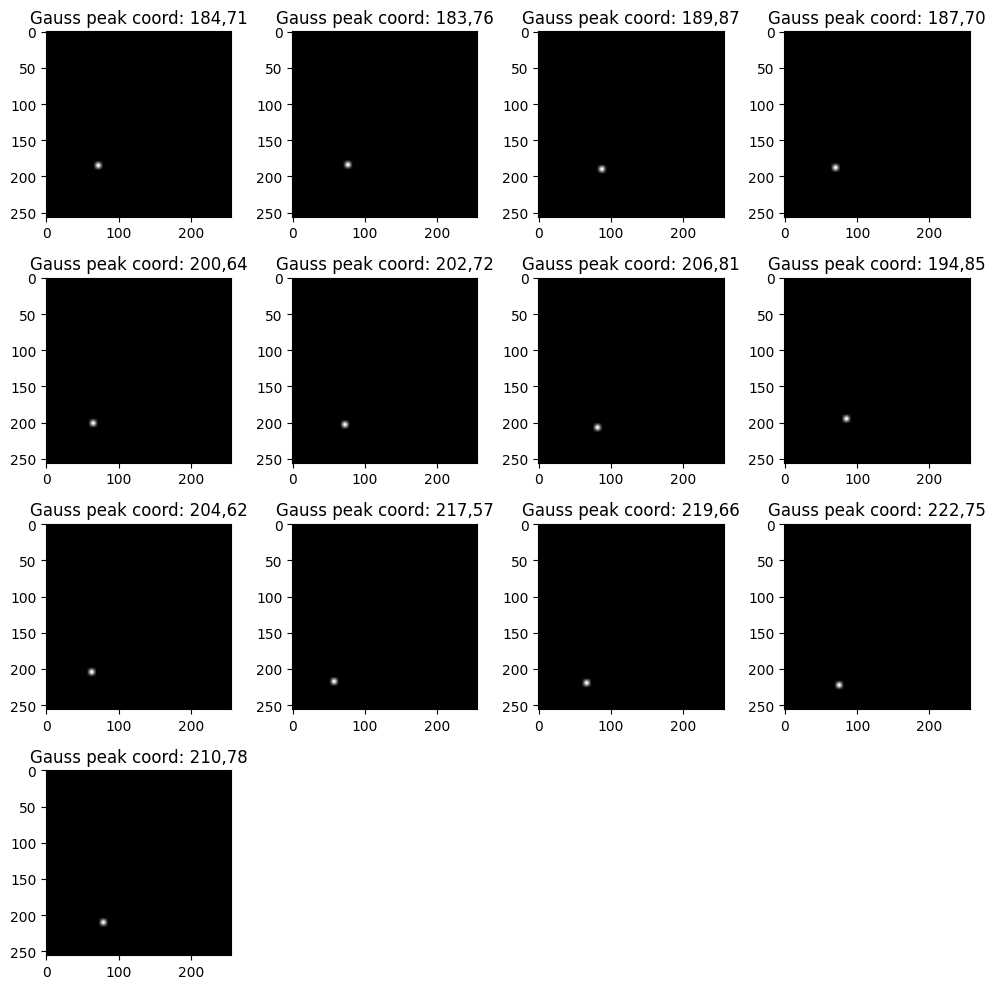

In [36]:
samples = []
v_shapes = []
for i, sample in enumerate(batch):
    print(type(sample['image']))
    print("image: ", sample['image'].shape)
    if 'v_landmarks'in sample and sample['v_landmarks'] is not None:
        print("v_landmarks: ", sample['v_landmarks'].shape)
    if 'f_landmarks' in sample and sample['f_landmarks'] is not None:
        print("f_landmarks: ", sample['f_landmarks'].shape)
    print()

    # plot
    v_landmarks = sample['v_landmarks'] if 'v_landmarks' in sample else None
    f_landmarks = sample['f_landmarks'] if 'f_landmarks' in sample else None
    image = sample['image'][0,...]

    plot_many_heatmaps(v_landmarks)
    print()
    break